<a href="https://colab.research.google.com/github/nikhilnimbalkar1/Coursera_Capstone/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle Of Neighborhoods - Mumbai

# Introduction/Business Problem 
The city of Mumbai consists of two distinct regions: Mumbai City district and Mumbai Suburban district, which form two separate revenue districts of Maharashtra.The city district region is also commonly referred to as the Island City or South Mumbai.Mumbai Suburban district lies to the north of Mumbai City district and comprises all of Mumbai's suburbs. The western part of the Mumbai Suburban district forms the Western Suburbs and the eastern portion forms the Eastern Suburbs. The suburbs of Chembur, Govandi, Mankhurd and Trombay lie to the south-east of the Eastern Suburbs. These suburbs are generally not considered as part of the Eastern Suburbs and are sometimes referred to as the "Harbour Suburbs".

We have data about the areas in Mumbai City, India. Our goal is to cluster venues in Mumbai according to their categories for eg. cafe. book shop, etc. We need to use FourSquare API to retrieve data about these venues from the locations data we have and use K means Clustering to form clusters of these venues and potray them on a map of the city.


# Data

The wikipedia page of the city contains location data with pincodes for the areas in [Mumbai City.](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai)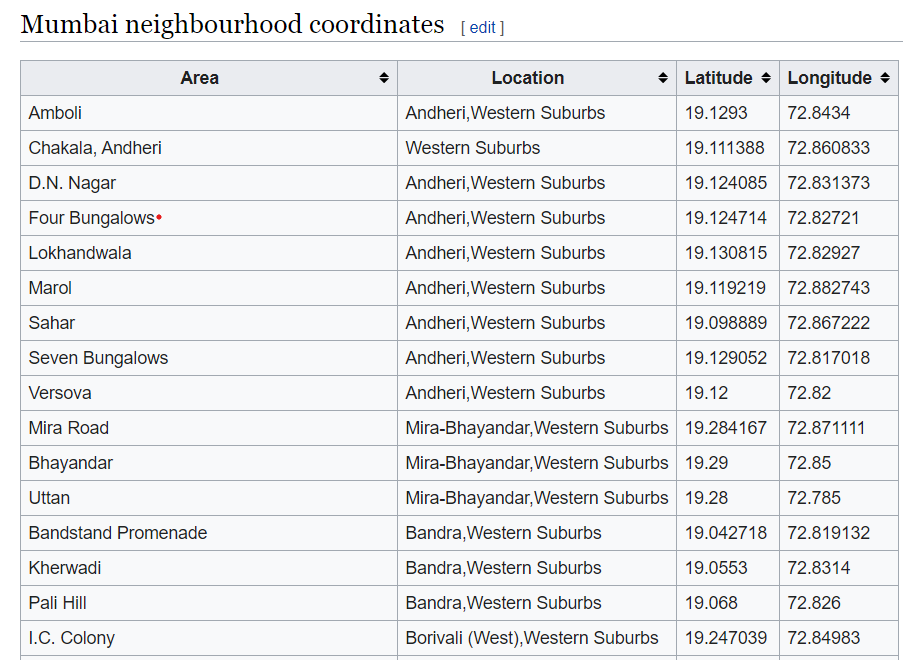

We will use BeautifulSoup library to scrape this data from the webpage, as we can see we already have the coordinates data available as well.

Further we will use FourSquare API to get venues close to the locations we have retrieved from the webpage using the coordinates columns and expand our data for clustering

Map of Mumbai with all available areas highlighted

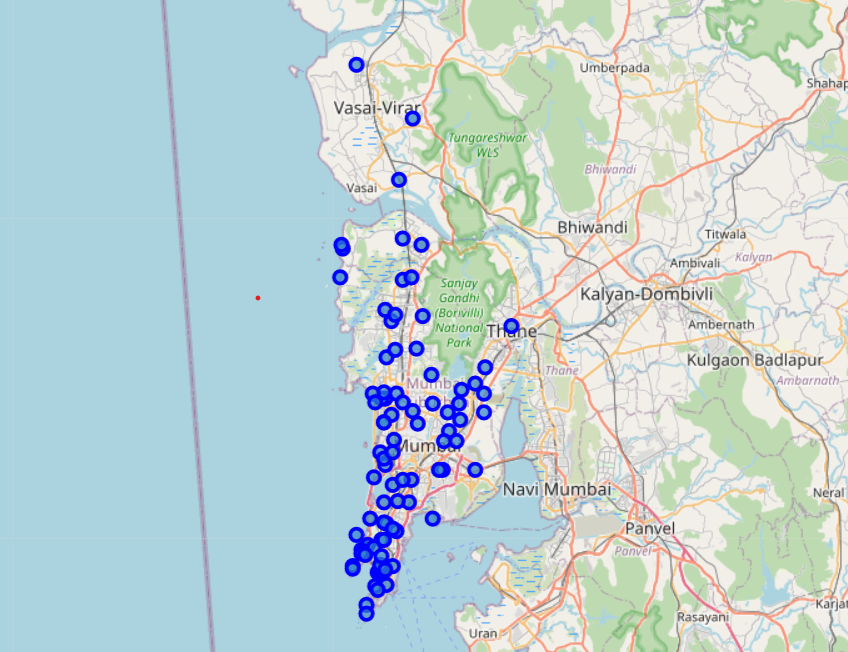

Data collected from FourSquare API for all areas in our dataset.

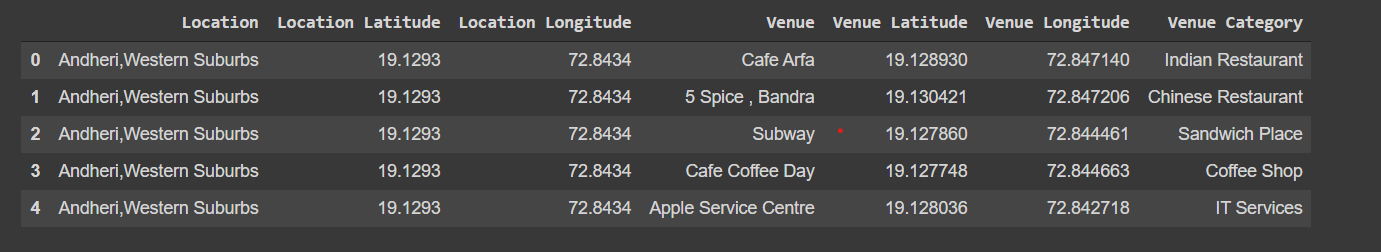

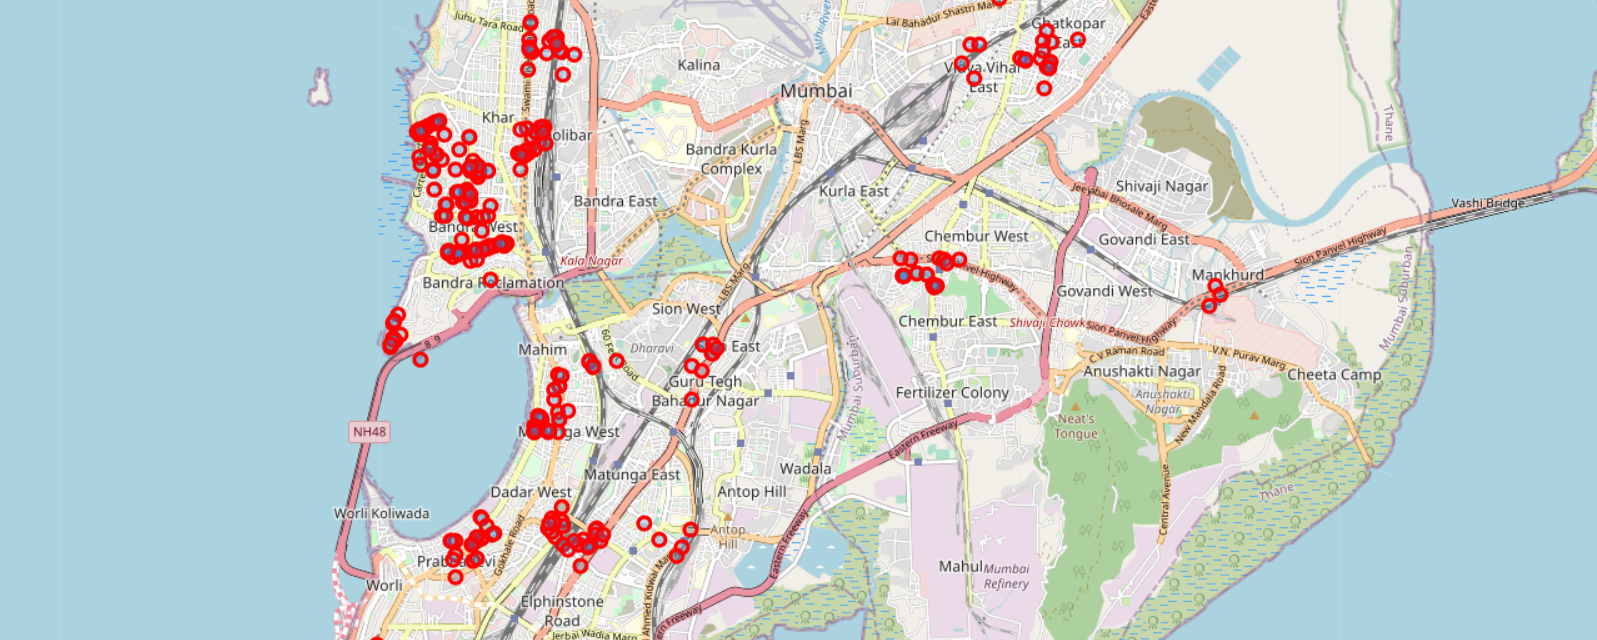

As you can see in the above image, we have venues from individual locations goruped together geographically.This is a cluster of sorts, but not the one we need.


This is the final data that will be used for k means clustering after preprocessing.



# One Hot Encoding
Since we are trying to find out what are the different kinds of venue categories present in each neighbourhood and then calculate the top 10 common venues to base our similarity on, we use the One Hot Encoding to work with our categorical datatype of the venue categories. This helps to convert the categorical data into numeric data.

We won't be using label encoding in this situation since label encoding might cause our machine learning model to have a bias or a sort of ranking which we are trying to avoid by using One Hot Encoding.

We perform one hot encoding and then calculate the mean of the grouped venue categories for each of the neighbourhoods.


In [ ]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Location'] = mumbai_venues['Location'] 

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

In [ ]:
mumbai_grouped = mumbai_onehot.groupby('Location').mean().reset_index()
mumbai_grouped

We get the following dataset with calculated mean of one hot encoded categories from our data


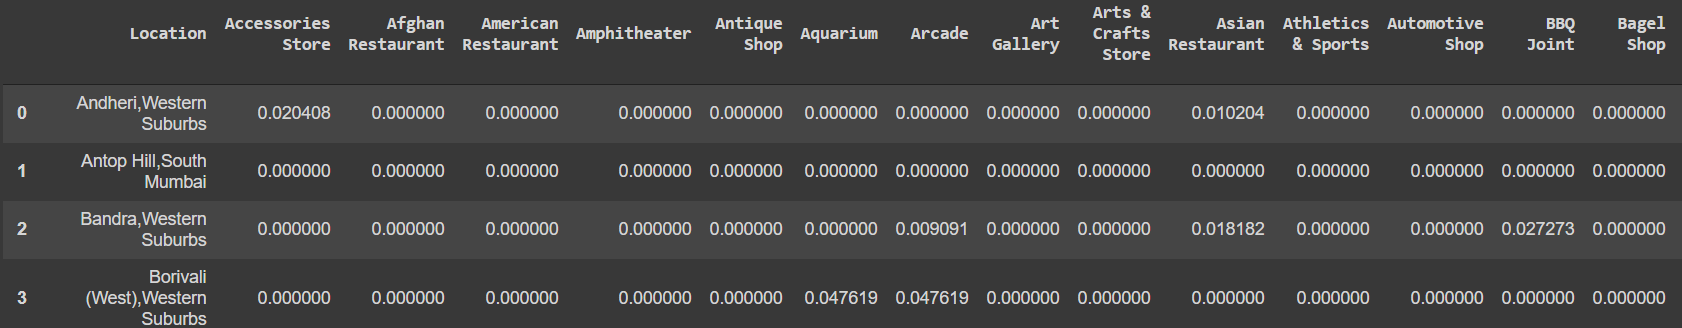

# Top Venues in the Neighbourhoods
In our next step, We need to rank and label the top venue categories in our neighbourhood.

Let's define a function to get the top venue categories in the neighbourhood

In [ ]:
num_top_venues = 5

for hood in mumbai_grouped['Location']:
    print("----"+hood+"----")
    temp = mumbai_grouped[mumbai_grouped['Location'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Location'] = mumbai_grouped['Location']

for ind in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

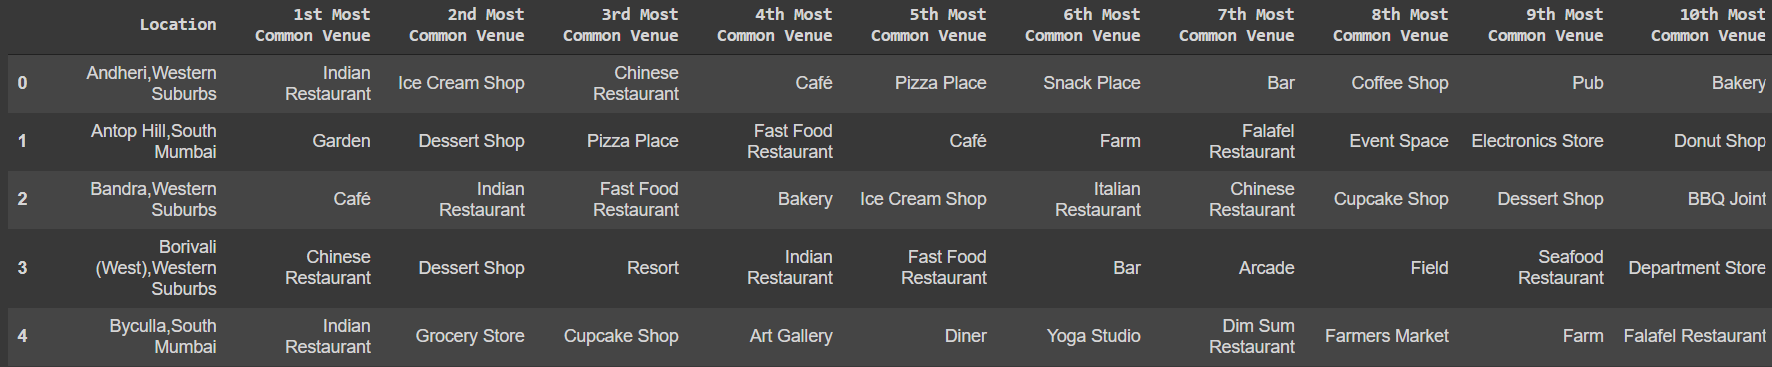

# **Model Building - KMeans**
Moving on to the most exciting part - Model Building! We will be using KMeans Clustering Machine learning algorithm to cluster similar neighbourhoods together. We will be going with the number of clusters as 5.

In [ ]:
# set number of clusters
kclusters = 5

mumbai_grouped_clustering = mumbai_grouped.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mumbai_merged = mumbai_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(neighborhoods_venues_sorted.set_index('Location'), on='Location',lsuffix="l")

mumbai_merged.head() 

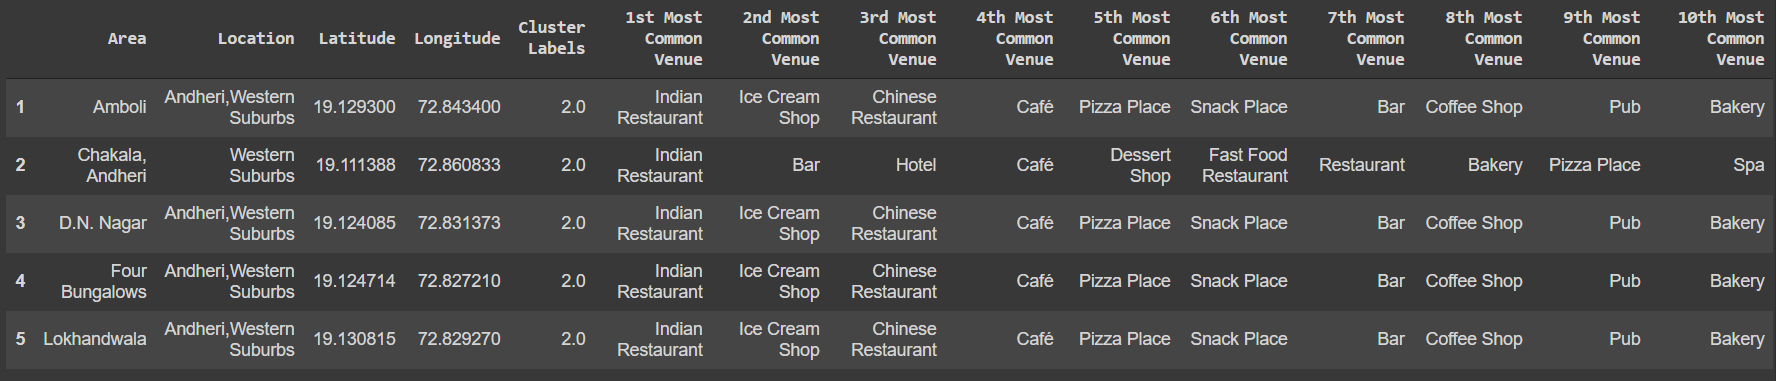

Visualizing the clustered Neighbourhoods
Our data is processed, missing data is collected and compiled. The Model is built. All that's remaining is to see the clustered neighbourhoods on the map. Again, we use Folium package to do so.

We drop all the NaN values to prevent data skew

In [ ]:
mumbai_merged.dropna(inplace = True)

# Map of clustered neighbourhoods of Mumbai:

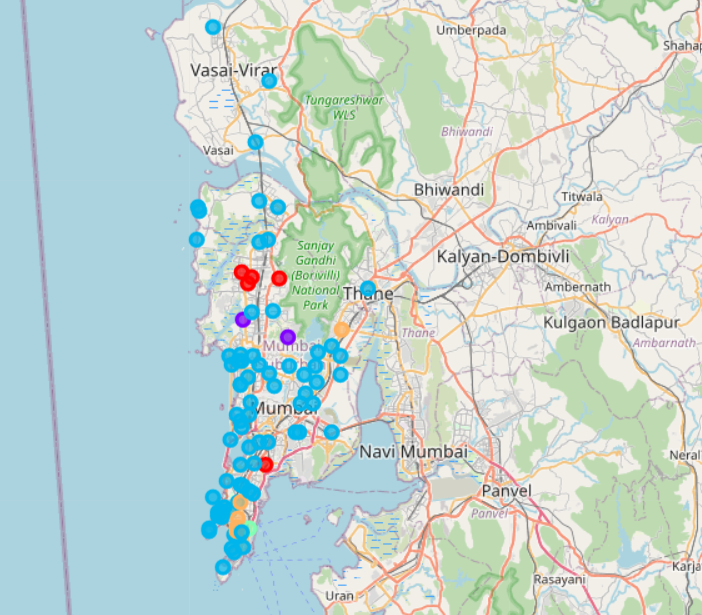

# Results and Discussion
As we can see in the final visualized map, the result of the clusters is not very multicultural. Majority of the most common venues in the city are Indian Restaurants, which is expected.
This is largely due to insufficient labeling of data in FourSqaure API fro this city. Beign an Indian citizen, I can safely say that although venues like restaurants in India are ofetn tagged as "Indian Restaurant", they offer a lot more diversity.
Mumbai beign one of the most inclusive city in India, sees tourists from all over the world and provides many cultural and casual activities for tourists.


# Conclusion
The purpose of this project was to explore the city of Mumbai and see how attractive it is to potential tourists and migrants. We exploredthe cities based on their postal codes and then extrapolated the common venues present in each of the neighbourhoods finally concluding with clustering similar neighbourhoods together.

We could see that each of the neighbourhoods the city has a wide variety of experiences to offer which is unique in it's own way. The cultural diversity is quite evident which also gives the feeling of a sense of inclusion.

Mumbai seems to offer a vacation stay or a romantic getaway with a lot of places to explore, beautiful landscapes, amazing food and a wide variety of culture. Overall, it's upto the stakeholders to decide which experience they would prefer more and which would more to their liking.

The detailed code is available on GitHub